# Gaussian Mixture Model

A GMM is an unsupervised learning algorithm that models a dataset using a mixture of several Gaussian distributions. It typically uses the Expectation-Maximization (EM) algorithm to estimate the parameters of these Gaussian components.

The main steps for implementing GMM are:

1. Initialize Parameters: Randomly initialize the parameters for each Gaussian component, including the means, variances, and weights.
2. Expectation Step (E-Step): Calculate the responsibilities (probability of each data point belonging to each Gaussian).
3. Maximization Step (M-Step): Update the parameters of the Gaussian components using the calculated responsibilities.
4. Iterate Until Convergence: Repeat the E-Step and M-Step until the log-likelihood converges.

In [1]:
import numpy as np
from typing import List, Tuple

# Step 1: Initialize parameters
def initialize_parameters(data: np.ndarray, n_components: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Initialize the means, variances, and weights of the Gaussian components.

    Args:
        data: Dataset of shape (n_samples, n_features).
        n_components: Number of Gaussian components.

    Returns:
        A tuple containing initial means, variances, and weights.
    """
    n_samples, n_features = data.shape
    means = data[np.random.choice(n_samples, n_components, replace=False)]
    variances = np.array([np.eye(n_features) for _ in range(n_components)])
    weights = np.ones(n_components) / n_components
    return means, variances, weights


# Step 2: Calculate Gaussian probability density function (PDF)
def gaussian_pdf(x: np.ndarray, mean: np.ndarray, cov: np.ndarray) -> float:
    """
    Calculate the Gaussian probability density function.

    Args:
        x: Data point of shape (n_features,).
        mean: Mean of the Gaussian of shape (n_features,).
        cov: Covariance matrix of shape (n_features, n_features).

    Returns:
        The probability density value of the data point.
    """
    n = x.shape[0]
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_factor = 1 / ((2 * np.pi) ** (n / 2) * (det_cov ** 0.5))
    exponent = -0.5 * np.dot(np.dot((x - mean).T, inv_cov), (x - mean))
    return norm_factor * np.exp(exponent)


# Step 3: Expectation Step (E-Step)
def expectation_step(data: np.ndarray, means: np.ndarray, variances: np.ndarray, weights: np.ndarray) -> np.ndarray:
    """
    Perform the E-Step to calculate the responsibilities.

    Args:
        data: Dataset of shape (n_samples, n_features).
        means: Means of the Gaussian components.
        variances: Covariance matrices of the Gaussian components.
        weights: Weights of the Gaussian components.

    Returns:
        Responsibilities matrix of shape (n_samples, n_components).
    """
    n_samples, n_components = data.shape[0], means.shape[0]
    responsibilities = np.zeros((n_samples, n_components))

    for i in range(n_samples):
        for j in range(n_components):
            responsibilities[i, j] = weights[j] * gaussian_pdf(data[i], means[j], variances[j])
        responsibilities[i, :] /= np.sum(responsibilities[i, :])

    return responsibilities


# Step 4: Maximization Step (M-Step)
def maximization_step(data: np.ndarray, responsibilities: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Perform the M-Step to update the parameters of the Gaussian components.

    Args:
        data: Dataset of shape (n_samples, n_features).
        responsibilities: Responsibilities matrix of shape (n_samples, n_components).

    Returns:
        Updated means, variances, and weights of the Gaussian components.
    """
    n_samples, n_features = data.shape
    n_components = responsibilities.shape[1]
    means = np.zeros((n_components, n_features))
    variances = np.zeros((n_components, n_features, n_features))
    weights = np.zeros(n_components)

    for j in range(n_components):
        responsibility_sum = np.sum(responsibilities[:, j])
        means[j] = np.sum(responsibilities[:, j, None] * data, axis=0) / responsibility_sum
        weights[j] = responsibility_sum / n_samples

        # Update covariance matrices
        cov_matrix = np.zeros((n_features, n_features))
        for i in range(n_samples):
            diff = (data[i] - means[j]).reshape(-1, 1)
            cov_matrix += responsibilities[i, j] * np.dot(diff, diff.T)
        variances[j] = cov_matrix / responsibility_sum

    return means, variances, weights


# Step 5: Log-Likelihood Calculation
def log_likelihood(data: np.ndarray, means: np.ndarray, variances: np.ndarray, weights: np.ndarray) -> float:
    """
    Calculate the log-likelihood of the data under the current GMM parameters.

    Args:
        data: Dataset of shape (n_samples, n_features).
        means: Means of the Gaussian components.
        variances: Covariance matrices of the Gaussian components.
        weights: Weights of the Gaussian components.

    Returns:
        Log-likelihood value.
    """
    n_samples, n_components = data.shape[0], means.shape[0]
    log_likelihood_value = 0.0

    for i in range(n_samples):
        prob_sum = 0.0
        for j in range(n_components):
            prob_sum += weights[j] * gaussian_pdf(data[i], means[j], variances[j])
        log_likelihood_value += np.log(prob_sum)

    return log_likelihood_value


# Step 6: Iterate until convergence
def fit_gmm(data: np.ndarray, n_components: int, max_iterations: int = 100, tol: float = 1e-4) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Fit the GMM to the data using the EM algorithm.

    Args:
        data: Dataset of shape (n_samples, n_features).
        n_components: Number of Gaussian components.
        max_iterations: Maximum number of iterations.
        tol: Convergence tolerance for log-likelihood.

    Returns:
        Final means, variances, and weights of the Gaussian components.
    """
    means, variances, weights = initialize_parameters(data, n_components)
    prev_log_likelihood = None

    for iteration in range(max_iterations):
        # E-Step
        responsibilities = expectation_step(data, means, variances, weights)

        # M-Step
        means, variances, weights = maximization_step(data, responsibilities)

        # Calculate log-likelihood
        current_log_likelihood = log_likelihood(data, means, variances, weights)

        # Check for convergence
        if prev_log_likelihood is not None and abs(current_log_likelihood - prev_log_likelihood) < tol:
            break

        prev_log_likelihood = current_log_likelihood

    return means, variances, weights

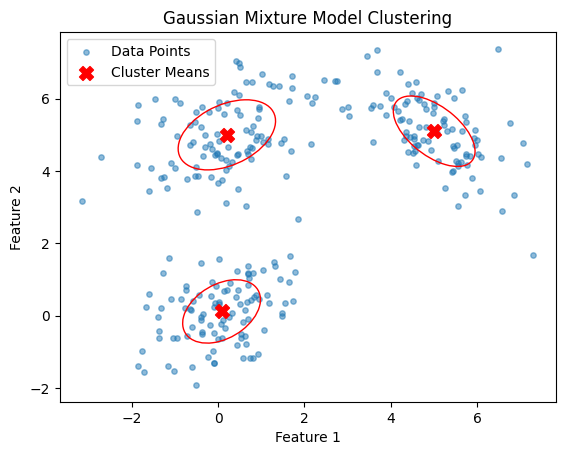

In [15]:
import matplotlib.pyplot as plt
# Visualization of GMM using randomly generated points
def visualize_gmm(data: np.ndarray, means: np.ndarray, variances: np.ndarray):
    """
    Visualize the GMM clusters along with the data points.

    Args:
        data: Dataset of shape (n_samples, n_features).
        means: Means of the Gaussian components.
        variances: Covariance matrices of the Gaussian components.
    """
    plt.scatter(data[:, 0], data[:, 1], s=15, label="Data Points", alpha=0.5)

    for i, mean in enumerate(means):
        cov = variances[i]
        eigvals, eigvecs = np.linalg.eigh(cov)
        angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
        angle = np.degrees(angle)
        width, height = 2 * np.sqrt(eigvals)
        
        ellipse = plt.matplotlib.patches.Ellipse((mean[0], mean[1]), width=width, height=height, angle=angle, edgecolor='red', facecolor='none')
        plt.gca().add_patch(ellipse)

    plt.scatter(means[:, 0], means[:, 1], c='red', s=100, marker='X', label="Cluster Means")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Gaussian Mixture Model Clustering")
    plt.legend()
    plt.show()


# Generate random data and visualize the fitted GMM
np.random.seed(42)
n_samples = 300
data1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], n_samples // 3)
data2 = np.random.multivariate_normal([5, 5], [[1, -0.5], [-0.5, 1]], n_samples // 3)
data3 = np.random.multivariate_normal([0, 5], [[1, 0.3], [0.3, 1]], n_samples // 3)
data = np.vstack((data1, data2, data3))

# Fit GMM
n_components = 3
means, variances, weights = fit_gmm(data, n_components)

# Visualize GMM
visualize_gmm(data, means, variances)